# STAT778: Final Project

In [1]:
import numpy as np
from numpy.random import uniform, normal, multivariate_normal, exponential, gamma
import scipy as sc
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
#it's not quite this. 3.2 does some sort of learning. how?
#we're measuring the likelihood (via the pdf) of x given our parameters and the result.
#THEN we combine that with our prior.
#Then we have a posterior belief about how possible these parameters are given the data we just saw and our prior belief.
#now we binarize this belief stochastically! and move onto the next iteration.

## Metropolis-Hastings with a Bayesian Linear Model

In [32]:
#metropolis-hastings functions
def sample(data: np.ndarray, N: int, B: int, start_theta: tuple, search_breadth: float=0.5):
    """Takes N samples via the Metropolis-Hastings algorithm, with B burn-in samples."""
    theta = start_theta
    for b in range(B): #burnin samples
        results = step(data, theta, search_breadth)
        theta = results['theta']
    
    samples = []
    for n in range(N): #real samples
        results = step(data, theta, search_breadth)
        theta = results['theta']
        samples.append(results)
    return samples

def step(data: np.ndarray, theta: tuple, search_breadth: float):
    """Takes one step in the Metropolis-Hastings algorithm by generating a new theta and comparing to a given theta."""
    theta_prime = sample_theta(theta, search_breadth) #sample a new set of parameters
    acceptance_log_prob = calc_acceptance_prob(theta, theta_prime, data, search_breadth) #calculate the probability of acceptance
    acceptance_prob = min(1,np.exp(acceptance_log_prob))
    accepted = acceptance_prob >= uniform() #probabilistically determine acceptance
    #need to set y here now too
    return {'accepted': accepted, 'acceptance_prob': acceptance_prob, 'theta': theta_prime if accepted else theta} #return results, update theta if samples accepted

def sample_theta(theta: tuple, search_breadth: float):
    """Samples theta parameters--slope, intercept, and standard deviation."""
    a,b,sigma = theta
    a,b = multivariate_normal([a,b], [[search_breadth**2,0],[0,search_breadth**2]])
    sigma = gamma(sigma*search_breadth*500, 1/(search_breadth*500))
    theta = a,b,sigma
    return theta

def calc_acceptance_prob(theta: tuple, theta_prime: tuple, data: np.ndarray, search_breadth: float):
    """Calculates acceptance probability by using a Bayesian linear model."""
    #y is also a factor in decision-making now too
    
    theta_likelihood = likelihood(theta, data)
    theta_prior = prior(theta)
    
    theta_p_likelihood = likelihood(theta_prime, data)
    theta_p_prior = prior(theta_prime)
    
    pr = proposal_ratio(theta, theta_prime, search_breadth)
    acceptance_ratio = theta_p_likelihood - theta_likelihood + theta_p_prior - theta_prior + pr
    return acceptance_ratio

#bayesian functions
def likelihood(theta: tuple, data: np.ndarray):
    """Calculates the likelihood component of our linear model by measuring our parameters theta on the given data."""
    a,b,sigma = theta
    x,y = data[0],data[1]
    likelihoods = sc.stats.norm.logpdf(y, loc=a*x+b, scale=sigma) #find the likelihood of a sample given a normal distribution specified by our parameters and the data
    return np.sum(likelihoods) #use log likelihood for stability

def prior(theta: tuple):
    """Calculates the prior component of our linear model, specified """
    a,b,sigma = theta
    ab_prior = sc.stats.multivariate_normal.logpdf([a,b], [0,0], [[100,0],[0,100]]) #cov defaults to 1
    sigma_prob = sc.stats.gamma.logpdf(sigma, 1, 1)
    return np.sum([ab_prior,sigma_prob])

def proposal_ratio(theta: tuple, theta_prime: tuple, search_breadth: float):
    """Offsets bidirectionality of chained samples."""
    a,b,sigma = theta
    a_p,b_p,sigma_p = theta_prime
    old_given_new_ab = sc.stats.multivariate_normal.logpdf([a,b],[a_p,b_p],[[search_breadth**2,0],[0,search_breadth**2]])
    old_given_new_sigma = sc.stats.gamma.logpdf(sigma, sigma_p*search_breadth*500, scale=1/(500*search_breadth))
    old_given_new = old_given_new_ab + old_given_new_sigma
    
    new_given_old_ab = sc.stats.multivariate_normal.logpdf([a_p,b_p],[a,b],[[search_breadth**2,0],[0,search_breadth**2]])
    new_given_old_sigma = sc.stats.gamma.logpdf(sigma_p, sigma*search_breadth*500, scale=1/(500*search_breadth))
    new_given_old = new_given_old_ab - new_given_old_sigma

    return old_given_new - new_given_old

In [4]:
X = np.random.rand(10000)
Y = np.random.normal(4,2,10000)
data = np.vstack((X,Y))
step(data,(4,0,2),0.5)

{'accepted': True,
 'acceptance_prob': 2.718281828459045,
 'theta': (4.326904920933997, 0.6682358378920995, 2.0718688171599235)}

In [80]:
#if we start on the correct parameters (so theoretically no burn-in) how does our acceptance rate vary with breadth value?
X = np.random.rand(10000)
Y = np.random.normal(-13,19,10000)
data = np.vstack((X,Y))
samples = sample(data, 20000, 0, (43,9,1), breadth)
df = pd.DataFrame(samples)
df[['a','b','sigma']] = pd.DataFrame(df['theta'].tolist(), index=df.index)
df = df.drop(['theta'], axis=1)

<ipython-input-32-98d49e65f681>:20: RuntimeWarning: overflow encountered in exp
  acceptance_prob = min(1,np.exp(acceptance_log_prob))


In [81]:
accepted,rejected = df[df['accepted']],df[~df['accepted']]

In [82]:
len(accepted)/len(df)

0.10135

In [83]:
accepted

,accepted,acceptance_prob,a,b,sigma
3,True,1.000000,42.953148,8.844563,1.013886
6,True,1.000000,42.897045,9.033473,1.261090
10,True,1.000000,42.763014,9.145596,1.272864
12,True,1.000000,42.760265,9.057361,1.683307
15,True,1.000000,42.626056,9.122161,1.749785
...,...,...,...,...,...
19928,True,0.023275,-0.347830,-12.651804,19.316593
19929,True,0.665082,-0.349673,-12.671455,19.270640
19930,True,0.444052,-0.414131,-12.556312,19.211137
19934,True,1.000000,-0.560979,-12.580116,18.974667


In [84]:
rejected

,accepted,acceptance_prob,a,b,sigma
0,False,0.000000e+00,43.000000,9.000000,1.000000
1,False,0.000000e+00,43.000000,9.000000,1.000000
2,False,0.000000e+00,43.000000,9.000000,1.000000
4,False,0.000000e+00,42.953148,8.844563,1.013886
5,False,0.000000e+00,42.953148,8.844563,1.013886
...,...,...,...,...,...
19994,False,4.913737e-04,-0.560979,-12.580116,18.974667
19995,False,5.110936e-03,-0.560979,-12.580116,18.974667
19996,False,4.255674e-16,-0.560979,-12.580116,18.974667
19998,False,1.701000e-06,-0.601853,-12.599775,18.987042


In [85]:
for param in ['a','b','sigma']:
    print(f"Values for {param}:\nAccepted: {accepted[param].mean()}\tRejected: {rejected[param].mean()}")

Values for a:
Accepted: 14.32652392028713	Rejected: 4.3238936607429075
Values for b:
Accepted: -11.932960845086926	Rejected: -13.6332169280272
Values for sigma:
Accepted: 22.737593886756926	Rejected: 19.800594018434907


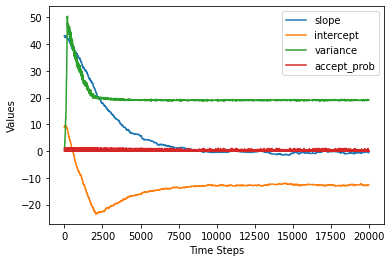

In [86]:
plt.plot(range(len(df)),df['a'], label='slope')
plt.plot(range(len(df)),df['b'], label='intercept')
plt.plot(range(len(df)),df['sigma'], label='variance')
plt.plot(range(len(df)),df['acceptance_prob'], label='accept_prob')
plt.xlabel("Time Steps")
plt.ylabel("Values")
plt.legend()

In [77]:
for start in [(0,0,1),(0,20,20),(0,40,40),(0,60,60),(0,80,80),(0,100,100)]:
    print(f"working on {start}")
    X = np.random.rand(10000)
    Y = np.random.normal(100,100,10000)
    data = np.vstack((X,Y))
    samples = sample(data, 20000, 0, start, breadth)
    
    df = pd.DataFrame(samples)
    df[['a','b','sigma']] = pd.DataFrame(df['theta'].tolist(), index=df.index)
    df = df.drop(['theta'], axis=1)
    
    plt.plot(range(len(df)),df['a'], label='slope')
    plt.plot(range(len(df)),df['b'], label='intercept')
    plt.plot(range(len(df)),df['sigma'], label='variance')
    plt.plot(range(len(df)),df['acceptance_prob'], label='accept_prob')
    plt.xlabel("Time Steps")
    plt.ylabel("Values")
    a,b,sigma = start
    plt.title(f"Convergence to N(100,100) from N({a}x+{b},{sigma})")
    plt.legend()
    plt.savefig(f'../plots/convergence_rate_{"".join(str(start).split(", "))}.jpg', bbox_inches='tight')
    plt.clf()

working on (0, 0, 1)


<ipython-input-32-98d49e65f681>:20: RuntimeWarning: overflow encountered in exp
  acceptance_prob = min(1,np.exp(acceptance_log_prob))


working on (0, 50, 50)


<ipython-input-32-98d49e65f681>:20: RuntimeWarning: overflow encountered in exp
  acceptance_prob = min(1,np.exp(acceptance_log_prob))


working on (0, 100, 100)


<Figure size 432x288 with 0 Axes>

In [78]:
df

,accepted,acceptance_prob,a,b,sigma
0,False,1.970839e-07,0.000000,100.000000,100.000000
1,False,1.049357e-04,0.000000,100.000000,100.000000
2,False,2.166475e-04,0.000000,100.000000,100.000000
3,False,5.220034e-02,0.000000,100.000000,100.000000
4,False,5.834174e-02,0.000000,100.000000,100.000000
...,...,...,...,...,...
19995,False,3.688303e-02,0.498517,98.808300,100.491814
19996,True,5.526840e-02,0.613191,98.698494,100.681001
19997,False,5.625946e-05,0.613191,98.698494,100.681001
19998,False,5.297580e-02,0.613191,98.698494,100.681001


## Zero Case: N(0,1)

In [79]:
X = np.random.rand(10000)
Y = np.random.normal(10,3,10000)
data = np.vstack((X,Y))
samples = sample(data, 30000, 0, (0,0,1), 1)
df = pd.DataFrame(samples)
df[['a','b','sigma']] = pd.DataFrame(df['theta'].tolist(), index=df.index)
df = df.drop(['theta'], axis=1)

<ipython-input-32-98d49e65f681>:20: RuntimeWarning: overflow encountered in exp
  acceptance_prob = min(1,np.exp(acceptance_log_prob))


In [ ]:
plt.scatter(X,Y)
plt.xlabel("X")
plt.ylabel("Y")
plt.title("The Data")

In [ ]:
df

In [ ]:
plt.plot(range(len(df)),df['a'], label='slope')
plt.plot(range(len(df)),df['b'], label='intercept')
plt.plot(range(len(df)),df['sigma'], label='variance')
plt.plot(range(len(df)),df['acceptance_prob'], label='accept_prob')
plt.xlabel("Time Steps")
plt.ylabel("Values")
plt.legend()

In [ ]:
plt.plot(range(len(df)),df['acceptance_prob'], label='accept_prob')
plt.xlabel("Time Steps")
plt.ylabel("Values")
plt.legend()

## Nonzero Case: N(4,2)

In [ ]:
X = np.random.rand(10000)
Y = np.random.normal(-13,8,10000)
data = np.vstack((X,Y))
samples = sample(data, 20000, 0, (0,4,2), 0.2)
df = pd.DataFrame(samples)
df[['a','b','sigma']] = pd.DataFrame(df['theta'].tolist(), index=df.index)
df = df.drop(['theta'], axis=1)

In [ ]:
plt.scatter(X,Y)
plt.xlabel("X")
plt.ylabel("Y")
plt.title("The Data")

In [ ]:
df
#it accepts every single one?
#does it arrive to the right parameters?
#effect of changing starting point?

In [ ]:
plt.plot(range(len(df)),df['a'], label='slope')
plt.plot(range(len(df)),df['b'], label='intercept')
plt.plot(range(len(df)),df['sigma'], label='variance')
#plt.plot(range(len(df)),df['acceptance_prob'], label='accept_prob')
plt.xlabel("Time Steps")
plt.ylabel("Values")
plt.legend()

In [ ]:
plt.scatter(range(len(df)),df['acceptance_prob'], label='accept_prob')
plt.xlabel("Time Steps")
plt.ylabel("Values")
plt.legend()
ax = plt.gca()
ax.set_ylim([0,1])

In [ ]:
df['acceptance_prob'].tolist()

In [ ]:
df.head(50)

In [ ]:
(df['accepted'].sum()/len(df))
#about 1.5% accepted with a 0.5 breadth rate
#about 2.5% accepted with a 0.2 breadth rate
#about 1% accepted with 0.01 breadth rate
#about 0.015% accepted with a 0.001 breadth rate

In [ ]:
df[df['accepted']]

## The Larger Case: N(50, 5)

In [ ]:
X = np.random.rand(100)
Y = np.random.normal(4,2,10000)
data = np.vstack((X,Y))
samples = sample(data, 30000, 0, (0,0,1), 1)
df = pd.DataFrame(samples)
df[['a','b','sigma']] = pd.DataFrame(df['theta'].tolist(), index=df.index)
df = df.drop(['theta'], axis=1)

In [ ]:
df

In [ ]:
plt.plot(range(len(df)),df['a'], label='slope')
plt.plot(range(len(df)),df['b'], label='intercept')
plt.plot(range(len(df)),df['sigma'], label='variance')
plt.plot(range(len(df)),df['acceptance_prob'], label='accept_prob')
plt.xlabel("Time Steps")
plt.ylabel("Values")
plt.legend()

In [ ]:
plt.plot(range(len(df)),df['acceptance_prob'], label='accept_prob')
plt.xlabel("Time Steps")
plt.ylabel("Values")
plt.legend()